2.Cropland distribution and phenological data

In [17]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.geometry import Point
import glob, os

In [18]:
counties = gpd.read_file("CHN_County.shp")
fires = gpd.read_file("cleaned_modis_hlj_gdf.shp")

fires = fires.to_crs(counties.crs)

In [19]:
maize_files = sorted(glob.glob("Heilongjiang_Maize_MA_*.tif"))
wheat_files = sorted(glob.glob("Heilongjiang_Wheat_MA_*.tif"))

maize_rasters = {int(f.split("_")[-1][:4]): f for f in maize_files}
wheat_rasters = {int(f.split("_")[-1][:4]): f for f in wheat_files}

In [20]:
fires["date"] = pd.to_datetime(fires["acq_date"])
fires["year"] = fires["date"].dt.year
fires["doy"] = fires["date"].dt.dayofyear

In [21]:
import rasterio
import numpy as np

def classify_crop_fast(gdf, raster_dict, crop_name):
    results = {}
    
    for year, raster_path in raster_dict.items():
        sub = gdf[gdf["year"] == year]
        if sub.empty:
            continue
        
        with rasterio.open(raster_path) as src:
            coords = [(geom.x, geom.y) for geom in sub.geometry]
            sampled_vals = list(src.sample(coords))
        
            sampled_vals = [v[0] for v in sampled_vals]
        
        sampled_vals = [np.nan if (val <= 0 or val > 366) else val for val in sampled_vals]
        
        results.update({idx: v for idx, v in zip(sub.index, sampled_vals)})
    
    gdf[crop_name] = pd.Series(results)
    return gdf

fires = classify_crop_fast(fires, maize_rasters, "maize_doy")
fires = classify_crop_fast(fires, wheat_rasters, "wheat_doy")

fires["burn_type"] = "non-crop"
mask_maize = fires["maize_doy"].between(fires["doy"]-30, fires["doy"]+30)
mask_wheat = fires["wheat_doy"].between(fires["doy"]-30, fires["doy"]+30)

fires.loc[mask_maize, "burn_type"] = "maize_burning"
fires.loc[mask_wheat, "burn_type"] = "wheat_burning"

In [22]:
fires_county = gpd.sjoin(
    fires[["geometry","burn_type"]],
    counties[["NAME_3","geometry"]],
    how="left",
    predicate="intersects"
)

county_stats = fires_county.groupby(["NAME_3","burn_type"]).size().unstack(fill_value=0)

county_stats.to_excel("T2_county_fire_stats.xlsx")
print(county_stats.head())

burn_type  maize_burning  non-crop  wheat_burning
NAME_3                                           
Acheng                11       836              0
Aihui                  6      4671              4
Aimin                  0        53              0
Anda                  33      2028              0
Angangxi               1       645              0


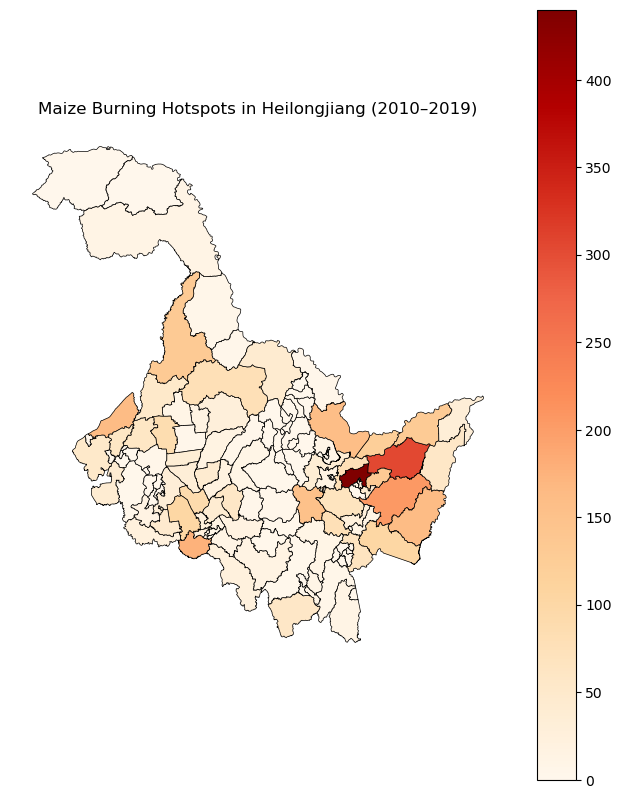

In [23]:
hlj_counties = counties[counties["NAME_1"] == "Heilongjiang"]

hlj_stats = hlj_counties.merge(county_stats, on="NAME_3", how="left").fillna(0)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

hlj_stats.plot(
    column="maize_burning",
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("Maize Burning Hotspots in Heilongjiang (2010–2019)")
ax.set_axis_off()
plt.savefig("T2_HLJ_maize_map.png", dpi=300, bbox_inches="tight")
plt.show()

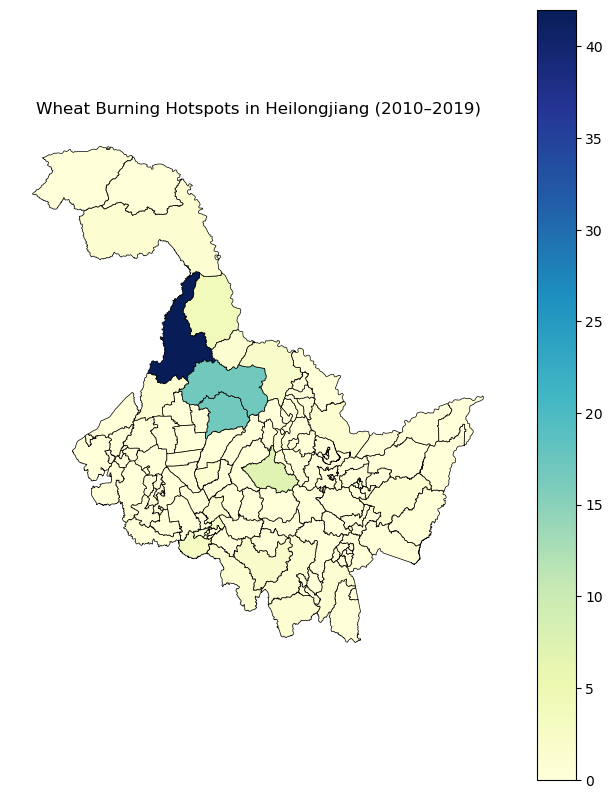

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

hlj_stats.plot(
    column="wheat_burning",
    cmap="YlGnBu",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("Wheat Burning Hotspots in Heilongjiang (2010–2019)")
ax.set_axis_off()
plt.savefig("T2_HLJ_wheat_map.png", dpi=300, bbox_inches="tight")
plt.show()

In [25]:
total_fires = len(fires) 

agri_fires = fires[fires["burn_type"].isin(["maize_burning","wheat_burning"])]
num_agri = len(agri_fires)

agri_rate = num_agri / total_fires * 100

print(f"Total fires: {total_fires}")
print(f"Agricultural fires: {num_agri}")
print(f"Agricultural burning proportion: {agri_rate:.2f}%")

Total fires: 200791
Agricultural fires: 4479
Agricultural burning proportion: 2.23%


3.FY (Fengyun) satellite-based straw burning fire point monitoring data:

In [81]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

In [82]:
fy = pd.read_excel("straw burning fire point monitoring data.xlsx")

print(fy.head())
print(fy.columns)

          时间     中心经度    中心纬度   省     市    县
0 2017-01-03  115.064  40.548  河北  张家口市  宣化县
1 2017-01-03  123.488  39.882  辽宁   丹东市  东港市
2 2017-01-14  122.115  41.444  辽宁   锦州市  北镇市
3 2017-01-17  115.661  32.540  安徽   阜阳市  阜南县
4 2017-01-18  122.603  41.834  辽宁   沈阳市  新民市
Index(['时间', '中心经度', '中心纬度', '省', '市', '县'], dtype='object')


In [85]:
counties = gpd.read_file("CHN_County.shp")
print(counties.columns)

Index(['å°å', 'åºåç ', 'å¿çº§', 'å¿çº§ç ', 'å¿çº§ç±»', 'å°çº§',
       'å°çº§ç ', 'å°çº§ç±»', 'ççº§', 'ççº§ç ', 'ççº§ç±»',
       'æ¾ç¨å', 'å¤æ³¨', 'ENG_NAME', 'VAR_NAME', 'code', 'NAME_3',
       'VAR_NAME3', 'GID_3', 'TYPE_3', 'NAME_2', 'VAR_NAME2', 'GID_2',
       'TYPE_2', 'NAME_1', 'VAR_NAME1', 'GID_1', 'TYPE_1', 'year', 'geometry'],
      dtype='object')


In [86]:
fy = fy.dropna(subset=['中心经度','中心纬度'])
fy['geometry'] = [Point(xy) for xy in zip(fy['中心经度'], fy['中心纬度'])]
fy_gdf = gpd.GeoDataFrame(fy, geometry='geometry', crs='EPSG:4326')

In [87]:
counties = counties.to_crs(epsg=4326)

fy_with_county = gpd.sjoin(fy_gdf, counties, how="left", predicate="within")

print(fy_with_county.columns)
print(fy_with_county.head())

Index(['时间', '中心经度', '中心纬度', '省', '市', '县', 'geometry', 'index_right',
       'å°å', 'åºåç ', 'å¿çº§', 'å¿çº§ç ', 'å¿çº§ç±»', 'å°çº§',
       'å°çº§ç ', 'å°çº§ç±»', 'ççº§', 'ççº§ç ', 'ççº§ç±»',
       'æ¾ç¨å', 'å¤æ³¨', 'ENG_NAME', 'VAR_NAME', 'code', 'NAME_3',
       'VAR_NAME3', 'GID_3', 'TYPE_3', 'NAME_2', 'VAR_NAME2', 'GID_2',
       'TYPE_2', 'NAME_1', 'VAR_NAME1', 'GID_1', 'TYPE_1', 'year'],
      dtype='object')
          时间     中心经度    中心纬度   省     市    县                geometry  \
0 2017-01-03  115.064  40.548  河北  张家口市  宣化县  POINT (115.064 40.548)   
1 2017-01-03  123.488  39.882  辽宁   丹东市  东港市  POINT (123.488 39.882)   
2 2017-01-14  122.115  41.444  辽宁   锦州市  北镇市  POINT (122.115 41.444)   
3 2017-01-17  115.661  32.540  安徽   阜阳市  阜南县   POINT (115.661 32.54)   
4 2017-01-18  122.603  41.834  辽宁   沈阳市  新民市  POINT (122.603 41.834)   

   index_right     å°å  åºåç   ... TYPE_3       NAME_2   VAR_NAME2  \
0         2849  å®£åå¿   130721.0  ...

In [88]:
heilongjiang_counties_hl = counties[counties['NAME_1'].str.contains('黑龙江')]

fy_with_county_hl = fy_with_county[fy_with_county['NAME_1'].str.contains('黑龙江')]

print(heilongjiang_counties_hl)
print(fy_with_county_hl)

Empty GeoDataFrame
Columns: [å°å, åºåç , å¿çº§, å¿çº§ç , å¿çº§ç±», å°çº§, å°çº§ç , å°çº§ç±», ççº§, ççº§ç , ççº§ç±», æ¾ç¨å, å¤æ³¨, ENG_NAME, VAR_NAME, code, NAME_3, VAR_NAME3, GID_3, TYPE_3, NAME_2, VAR_NAME2, GID_2, TYPE_2, NAME_1, VAR_NAME1, GID_1, TYPE_1, year, geometry]
Index: []

[0 rows x 30 columns]
Empty GeoDataFrame
Columns: [时间, 中心经度, 中心纬度, 省, 市, 县, geometry, index_right, å°å, åºåç , å¿çº§, å¿çº§ç , å¿çº§ç±», å°çº§, å°çº§ç , å°çº§ç±», ççº§, ççº§ç , ççº§ç±», æ¾ç¨å, å¤æ³¨, ENG_NAME, VAR_NAME, code, NAME_3, VAR_NAME3, GID_3, TYPE_3, NAME_2, VAR_NAME2, GID_2, TYPE_2, NAME_1, VAR_NAME1, GID_1, TYPE_1, year]
Index: []

[0 rows x 37 columns]


In [89]:
fy_with_county_hl['date'] = pd.to_datetime(fy_with_county_hl['时间'])
fy_with_county_hl['month'] = fy_with_county_hl['date'].dt.to_period('M')
fy_with_county_hl['year'] = fy_with_county_hl['date'].dt.year

In [90]:
monthly_trend = fy_with_county_hl.groupby('month').size().reset_index(name='fire_count')
print(monthly_trend)

Empty DataFrame
Columns: [month, fire_count]
Index: []


In [91]:
county_trend = fy_with_county_hl.groupby('NAME_3').size().reset_index(name='fire_count')
print(county_trend)

Empty DataFrame
Columns: [NAME_3, fire_count]
Index: []


In [94]:
heilongjiang_counties_hl = counties[counties['NAME_1'] == 'Heilongjiang']
print(heilongjiang_counties_hl)

            å°å  åºåç         å¿çº§  å¿çº§ç   å¿çº§ç±»  \
2        é¿ååº   230112.0     é¿ååº   230112.0  å¸è¾åº   
16       ç±è¾åº   231102.0     ç±è¾åº   231102.0  å¸è¾åº   
17       ç±æ°åº   231004.0     ç±æ°åº   231004.0  å¸è¾åº   
19       å®è¾¾å¸   231281.0     å®è¾¾å¸   231281.0  å¿çº§å¸   
46    æææºªåº   230205.0  æææºªåº   230205.0  å¸è¾åº   
...            ...        ...           ...        ...        ...   
2832     æ°éåº   230707.0     æ°éåº   230707.0  å¸è¾åº   
2833     ç¾æºªåº   230708.0     ç¾æºªåº   230708.0  å¸è¾åº   
2834  éå±±å±¯åº   230709.0  éå±±å±¯åº   230709.0  å¸è¾åº   
2853     æè¿å¿   230883.0     æè¿å¿   230883.0        å¿   
2854     é¥¶æ²³å¿   230524.0     é¥¶æ²³å¿   230524.0        å¿   

               å°çº§  å°çº§ç   å°çº§ç±»        ççº§  ççº§ç   ...  \
2        åå°æ»¨å¸   230100.0  å°çº§å¸  é»é¾æ±ç   230000.0  ...   
16          é»æ²

In [95]:
fy_with_county_hl = fy_with_county[fy_with_county['NAME_1'] == 'Heilongjiang']
print(fy_with_county_hl)

             时间     中心经度    中心纬度    省      市           县  \
58   2016-11-01  124.534  46.592  黑龙江    大庆市  杜尔伯特蒙古族自治县   
59   2016-11-01  124.547  46.673  黑龙江    大庆市  杜尔伯特蒙古族自治县   
60   2016-11-01  124.561  47.315  黑龙江    大庆市         林甸县   
61   2016-11-01  125.626  45.603  黑龙江    大庆市         肇源县   
62   2016-11-01  125.363  45.817  黑龙江    大庆市         肇州县   
...         ...      ...     ...  ...    ...         ...   
2545 2016-08-29  126.514  49.168  黑龙江    黑河市       五大连池市   
2546 2016-08-29  126.914  48.908  黑龙江    黑河市       五大连池市   
2547 2016-08-29  127.192  48.961  黑龙江    黑河市       五大连池市   
2548 2016-08-29  127.256  48.942  黑龙江    黑河市       五大连池市   
2549 2016-08-29  124.225  47.498  黑龙江  齐齐哈尔市         富裕县   

                    geometry  index_right                          å°å  \
58    POINT (124.534 46.592)          380  æå°ä¼¯ç¹èå¤æèªæ²»å¿   
59    POINT (124.547 46.673)          380  æå°ä¼¯ç¹èå¤æèªæ²»å¿   
60    POINT (124.561 47.315)         1149       

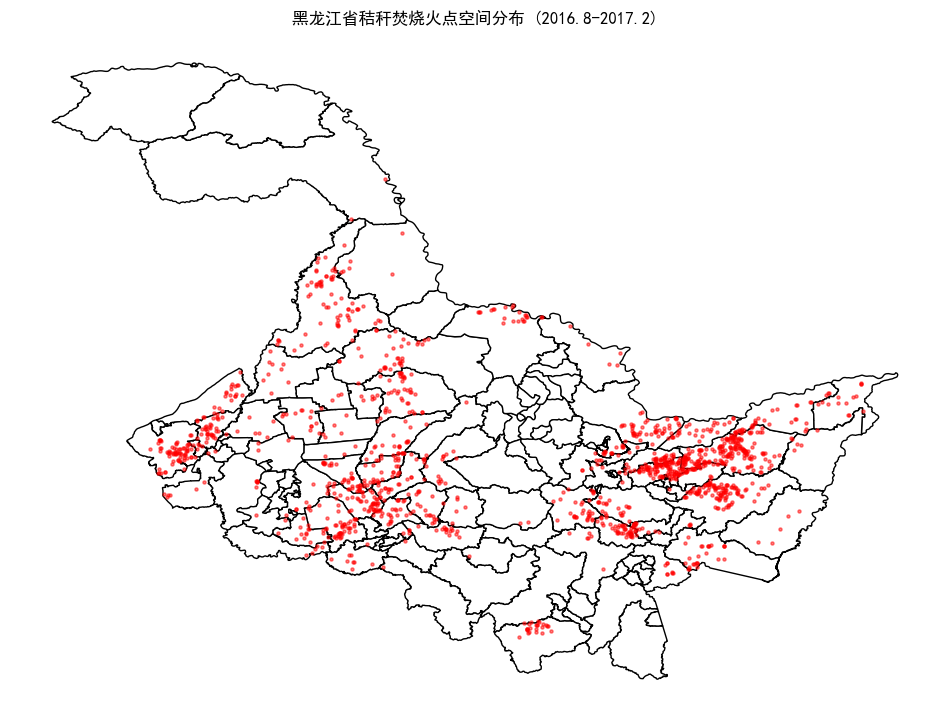

In [96]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
heilongjiang_counties_hl.plot(ax=ax, color='white', edgecolor='black')
fy_with_county_hl.plot(ax=ax, markersize=5, color='red', alpha=0.5)

ax.set_aspect('equal')
plt.title("黑龙江省秸秆焚烧火点空间分布 (2016.8-2017.2)")
plt.axis('off')
plt.show()

In [100]:
fy_with_county_hl.loc[:, 'month'] = fy_with_county_hl['时间'].dt.to_period('M')

fire_trend = fy_with_county_hl.groupby('month').size().reset_index(name='fire_count')

print(fire_trend)

     month  fire_count
0  2016-08          73
1  2016-09           7
2  2016-10         702
3  2016-11         715


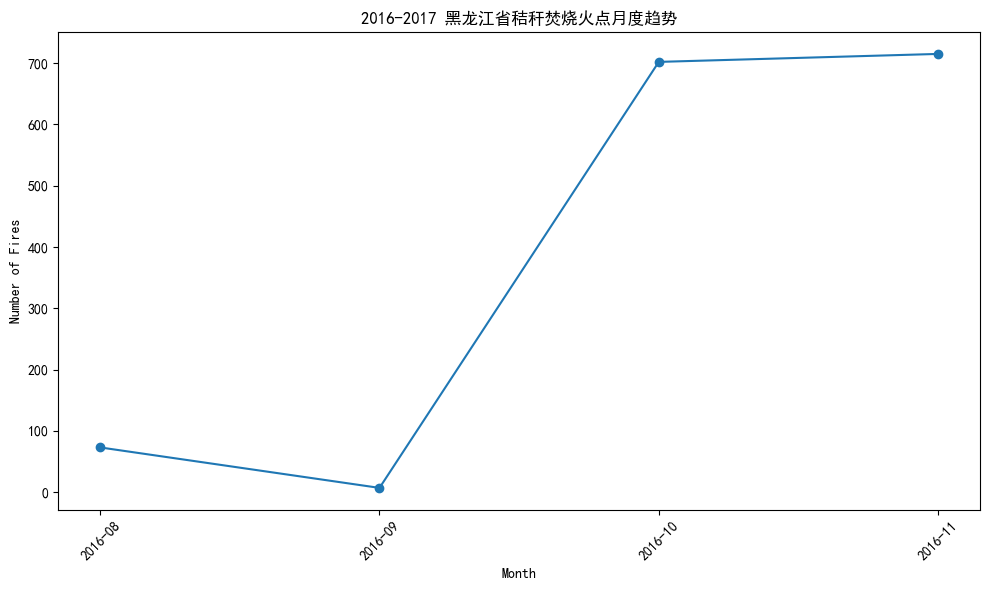

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(fire_trend['month'].astype(str), fire_trend['fire_count'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.title('2016-2017 黑龙江省秸秆焚烧火点月度趋势')
plt.tight_layout()
plt.show()

Summary：
By analyzing the straw burning fire points in Heilongjiang Province from 2016 to 2017, both spatially and temporally, the following conclusions were drawn:

Data Cleaning and Filtering: Records with missing longitude or latitude were removed, and only data within Heilongjiang Province were retained.

Map Visualization: Using GeoPandas, a map of Heilongjiang was plotted with fire points marked, allowing a clear observation of spatial distribution.

Trend Analysis: Monthly fire counts were calculated and plotted in a line chart, showing a clear seasonal pattern. Fire activities peaked during the autumn harvest season (September to November) and declined significantly in winter.

Analytical Value: This analysis provides visual evidence for agricultural management, environmental monitoring, and straw handling policies, helping decision-makers implement targeted control measures during high-risk periods.